# EECS 545 (WN 2023) Assignment 1: Linear Regression

In this assignment, you will implement a simple linear regression algorithm covered in Lecture 2-3.

In [220]:
from IPython.display import display_html, HTML

display_html(HTML('''
<style type="text/css">
  .instruction { background-color: yellow; font-weight:bold; padding: 3px; }
</style>
'''));

### CHANGELOG

- rev0: Initial release (23. 1. 10. 1PM)
- rev1: Fixed a minor typo in cell [12]: `w=w_gd` -> `w=w_sgd`
- rev4: 2023. 1. 20. 6PM
    1. **Made the training objective consistent with the problemset and lecture notes.**
        - More specifically, the training objective (or training loss) should be $E(\mathbf w)$ (note the coefficient $\frac{1}{2}$ instead of $\frac{1}{2N}$), where the MSE error has the $\frac{1}{2N}$, i.e. MSE = $E(\mathbf w) \times N$).
        - 2(a): We will no longer ask you to implement MSE, because this will be only used for testing. Removed the two cells about MSE. The implementation of `linear_regression.MSE()` will be provided in the python code, just in case you could be using it somewhere.
        - 2(c): <u>`info["train_losses"]` should be a list of training errors per `linear_regression.loss()` instead of `linear_regression.MSE()`</u>. 
        - 2(c): The y-axis is now the training objective $E(\mathbf w)$, changed from $MSE$. This would have an effect of scaling up all the values by a factor of $N = 20$. 
        - 2(c): We know this is a breaking change. Therefore, <u>it is OK that your submission (code and write-up) is based on the MSE instead of the corrected training objective</u> (so that you don't need to bother changing and re-working on your submission); we will make both version as correct answers and you should not lose any points due to this change. 
        
        <br/>
        
    
    1. To avoid confusion, removed the parameter `lam` from the methods `batch_gradient_descent` and `stochastic_gradient_descent` for 2(a)-(b) in the skeleton code. You can leave your previous implementations and written write-up answers (if you started early) unchanged if you started early before this revision, as we will not use or test the `lam` parameters. Regularization (`lambda`) is needed for 2.3 only where we work on the closed form solution, so we no longer require `lambda` for BGD and SGD.
    
    1. Minor: Suggested use of `ax.set_xscale('log')` for 2(g). See piazza @71 for more details.

## Your ID

<span class="instruction">Before starting the assignment, please fill in the following cell.</span>

In [221]:
###################################################################
# Enter your first and last name, e.g. "John Doe"                 #
# for example,                                                    #
# __NAME__ = "Honglak Lee"                                        #
# __UNIQID__ = "honglak"                                          #
###################################################################
__NAME__ = "Mo Xu"
__UNIQID__ = "xmo"
# raise NotImplementedError("TODO: Add your implementation here.")
###################################################################
#                        END OF YOUR CODE                         #
###################################################################

print(f"Your name and email: {__NAME__} <{__UNIQID__}@umich.edu>")
assert __NAME__ and __UNIQID__

Your name and email: Mo Xu <xmo@umich.edu>


## Setup

We will need to have some boilerplate code to set up this notebook. First, run the following cell which loads the [autoreload](https://ipython.readthedocs.io/en/stable/config/extensions/autoreload.html) IPython magic: this allows us to automatically import and hotload the source files you will be modifying (e.g. `linear_regression.py`) into the notebook for a seamless editing and debugging expreience.

NOTE: It is usually a good practice to implement code ("business logic" or core computation) as a "library", usually implemented with a python module, which can be imported from ipython(jupyter) notebook rather than implementing everything in jupyter notebook cells. This practice would help make your code more testable and well-structured.

In [222]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


More boilerplates follow:

In [223]:
# Import some libraries that are needed in this assignment.
# Note: You should not import or use other packages than numpy and matplotlib that would
# trivialize your work. Actually, you will never need to import them.
import numpy as np
import matplotlib
import matplotlib.pyplot as plt

# If you run into ImportError (ModuleNotFoundError), uncomment and execute the following line.
# !pip install numpy matplotlib

In [224]:
# This is the python module you are going to implement. See linear_regression.py
import linear_regression

import sys
import datetime

# Dump environment information
print("Current time:", datetime.datetime.now())
print(f"python: {sys.version}")
print(f"numpy: {np.__version__}")
print(f"matplotlib: {matplotlib.__version__}")

# Use high-resolution images for inline matplotlib possible whenever possible
%config InlineBackend.figure_format = 'retina'

# Default params for plot
plt.rcParams['figure.figsize'] = 10, 5
plt.rcParams['font.size'] = 20

Current time: 2023-01-24 21:54:09.625623
python: 3.10.8 | packaged by conda-forge | (main, Nov 22 2022, 08:16:33) [MSC v.1929 64 bit (AMD64)]
numpy: 1.24.1
matplotlib: 3.6.3


## 2.1. Implementing GD and SGD

### Load the Dataset

Please execute the following cell to load the sample data provided. We also generate the feature vector $\phi(\mathbf{x}^{(i)})$ for each data point $\mathbf x^{(i)}$.

In [225]:
x_train, y_train, x_test, y_test = linear_regression.load_data()
X_train = linear_regression.generate_polynomial_features(x_train, M=1)
X_test = linear_regression.generate_polynomial_features(x_test, M=1)

print(f"{X_train.shape=}")
print(f"{y_train.shape=}")
print(f"{X_test.shape=}")
print(f"{y_test.shape=}")

X_train.shape=(20, 2)
y_train.shape=(20,)
X_test.shape=(20, 2)
y_test.shape=(20,)


### 2(a): Batch Gradient Descent (GD)

<span class="instruction">Now, implement the iterative batch gradient descent method</span> in the `linear_regression.batch_grad()` function. The function prototype is given as follows:

In [226]:
linear_regression.batch_gradient_descent?

Signature:
linear_regression.batch_gradient_descent(
    X_train: numpy.ndarray,
    y_train: numpy.ndarray,
    *,
    eta: float = 0.01,
    max_epochs: int = 10000,
) -> Tuple[numpy.ndarray, Dict[str, Any]]
Docstring:
Batch gradient descent for linear regression that fits the
feature matrix `X_train` to target `y_train`.

Args:
    X_train: the feature matrix, with shape (N, M+1).
    y_train: the target label for regression, with shape (N, ).
    eta: Learning rate.
    max_epochs: Maximum iterations (epochs) allowed.
Returns: A tuple (w, info)
    w: The coefficient of linear regression found by GD. Shape (M+1, ).
    info: A dict that contains additional information (see the notebook).
File:      e:\umichcourses\eecs 545_machine learning\hw1\hw1.rev4\linear_regression.py
Type:      function

Please initialize the weights with zero vectors.

Alright, now let's run the GD solver with the provided sample data, fitting the training set. The function should return a 2-tuple `(w, info)`, where:

- `w` : The coefficients generated by the optimization method.
- `info`: The additional information as much as needed: for instance, number of epochs/iterations ran, etc.

In [227]:
w_gd, info = linear_regression.batch_gradient_descent(X_train, y_train)
mse_train_loss = linear_regression.loss(X_train, y_train, w=w_gd)

print(f"w = {w_gd}")
print(f"Training loss after convergence = {mse_train_loss}")

assert mse_train_loss <= 0.2 * y_train.shape[0]   # if you implemented Batch GD correctly, it should converge.

w = [ 1.10173303 -1.11566145]
Training loss after convergence = 3.99261579113425


Let's also measure the validation (test) error:

In [228]:
mse_test_error = linear_regression.loss(X_test, y_test, w=w_gd)

print(f"w = {w_gd}")
print(f"Test loss = {mse_test_error}")

w = [ 1.10173303 -1.11566145]
Test loss = 2.7549618497645154


### 2(a): Stochastic Gradient Descent (SGD)

Next, <span class="instruction">implement the iterative stochastic gradient descent method</span> in the `linear_regression.stochastic_gradient_descent()`, and let's repeat the same process with SGD.

In [229]:
w_sgd, info = linear_regression.stochastic_gradient_descent(X_train, y_train)
mse_train_loss = linear_regression.loss(X_train, y_train, w=w_sgd)

print(f"w = {w_sgd}")
print(f"Training loss after convergence = {mse_train_loss}")

assert mse_train_loss <= 0.2 * y_train.shape[0]   # if you implemented SGD correctly, it should converge.

w = [ 1.1305042  -1.17906577]
Training loss after convergence = 3.848954685653815


In [230]:
mse_test_loss = linear_regression.loss(X_test, y_test, w=w_sgd)

print(f"w = {w_sgd}")
print(f"Test loss = {mse_test_loss}")

w = [ 1.1305042  -1.17906577]
Test loss = 2.6792041797481567


### 2(b): Hyperparameter search

At this point, you can answer questions 2(a) and 2(b). Write down the coefficients generated by each of the optimization
methods after a bit of hyperparameter search.


<span class="instruction">Feel free to add additional cells here to find the best hyperparameters.</span> Make plots if necessary. Which hyperparameters have you tried, and which one works the best for you?

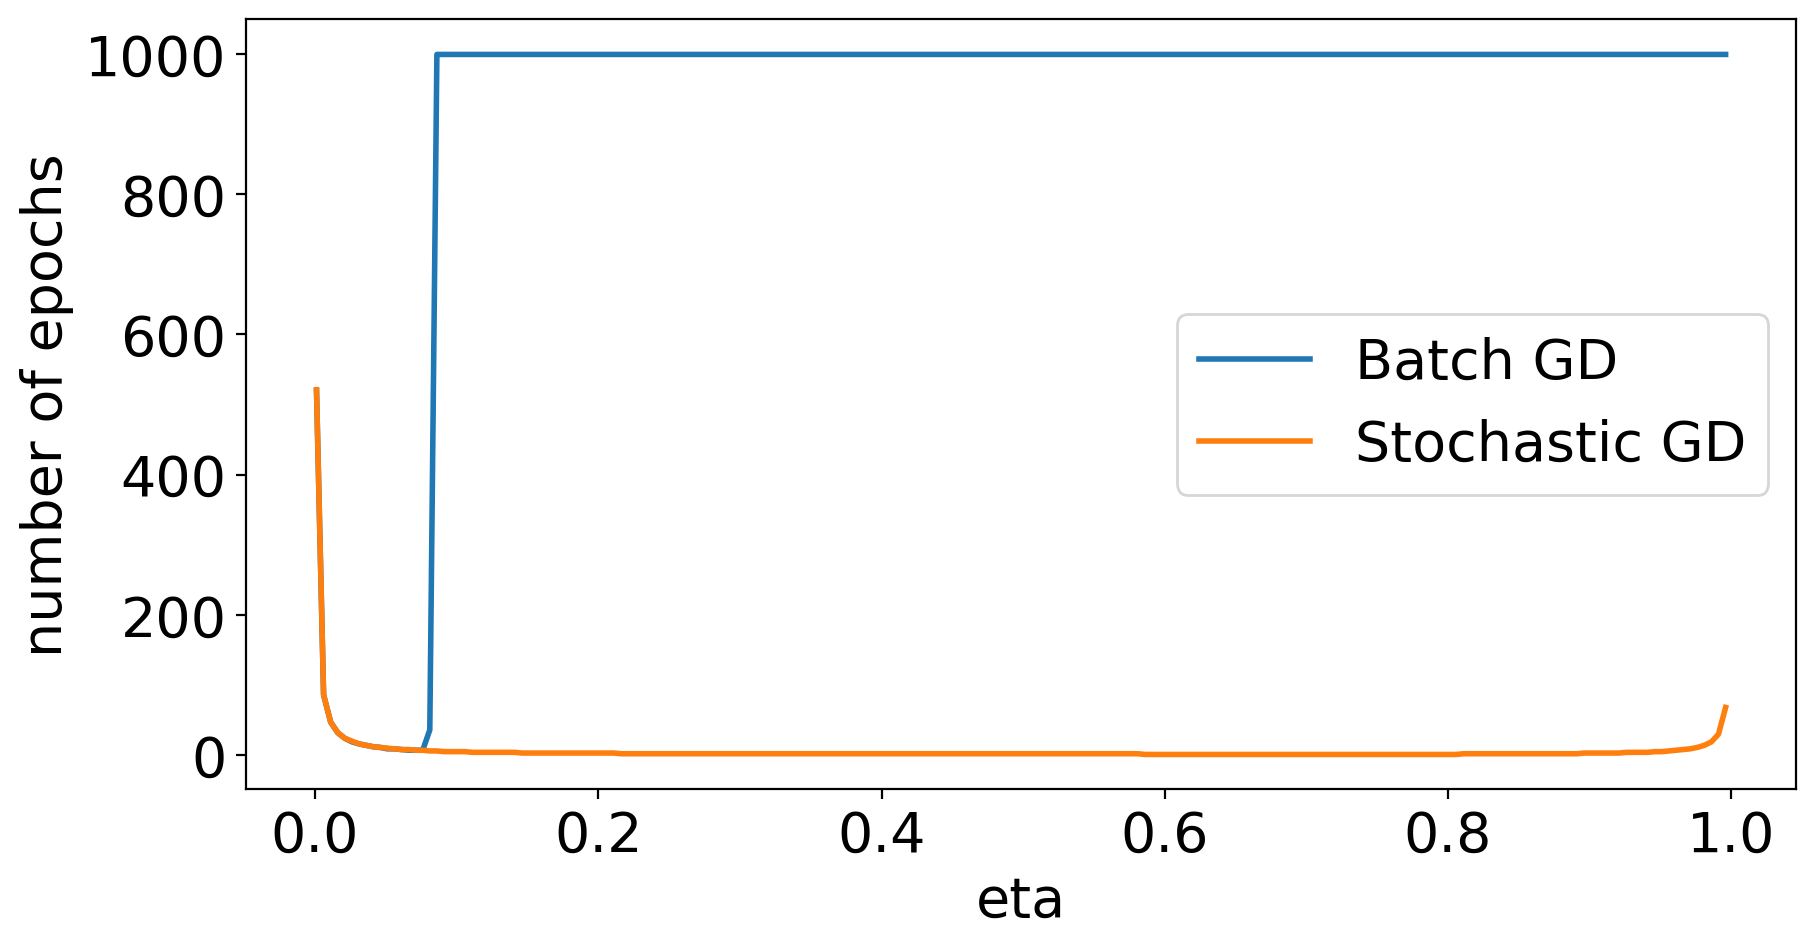

In [231]:
#############################################################################
# TODO: # Add your work for 2(b).
#############################################################################
eta_arr = np.arange(1e-3,1,5e-3)
iteration_gd = np.zeros_like(eta_arr)
iteration_sgd = np.zeros_like(eta_arr)
for i in range(len(eta_arr)):
    w_gd, info_gd = linear_regression.batch_gradient_descent(X_train, y_train, eta=eta_arr[i],max_epochs=1000)
    w_sgd, info_sgd = linear_regression.stochastic_gradient_descent(X_train, y_train, eta=eta_arr[i],max_epochs=1000)
    
    iteration_gd[i] = info_gd["number of epochs"]
    iteration_sgd[i] = info_sgd["number of epochs"]

fig, ax = plt.subplots()
ax.plot(eta_arr, iteration_gd, linewidth=2.0, label='Batch GD')
ax.plot(eta_arr, iteration_sgd, linewidth=2.0, label='Stochastic GD')
ax.set_ylabel("number of epochs")   # Note: see the CHANGELOG (rev4).
ax.set_xlabel("eta")
ax.legend()
plt.show()
eta_gd = eta_arr[np.argmin(iteration_gd)]
eta_sgd = eta_arr[np.argmin(iteration_sgd)]
#############################################################################
#                          END OF YOUR CODE                                 #
#############################################################################

### 2(c): Drawing Learning Curves for GD and SGD

We will compare two optimizations in terms of the number of epochs required to converge.

You can modify the `batch_gradient_descent` and `stochastic_gradient_descent` functions to make them return additional information and statistics into the `info` dictionary. Note that the use of `info` dictionary is actually a very common practice in ML implementations (e.g. [torch.grad](https://pytorch.org/functorch/stable/generated/functorch.grad.html?highlight=has_aux), [jax.grad](https://jax.readthedocs.io/en/latest/_autosummary/jax.grad.html?highlight=has_aux)). 

<span class="instruction">Modify GD and SGD implementations such that the `info` dictionary would contain:</span>
    
- `info["train_losses"]`: a `list` (or 1D `ndarray`) of *training* errors ($E(\mathbf w)$, or MSE * $N$), one scalar value per epoch (batch GD) or iteration (SGD) until convergence.
- The `info` dict may contain any additional entries as well, as you want.

In this question, we will call the training process **converged** when the MSE error on the training dataset is lower than 0.2 *consistently*, that is, for 100 consecutive epochs.

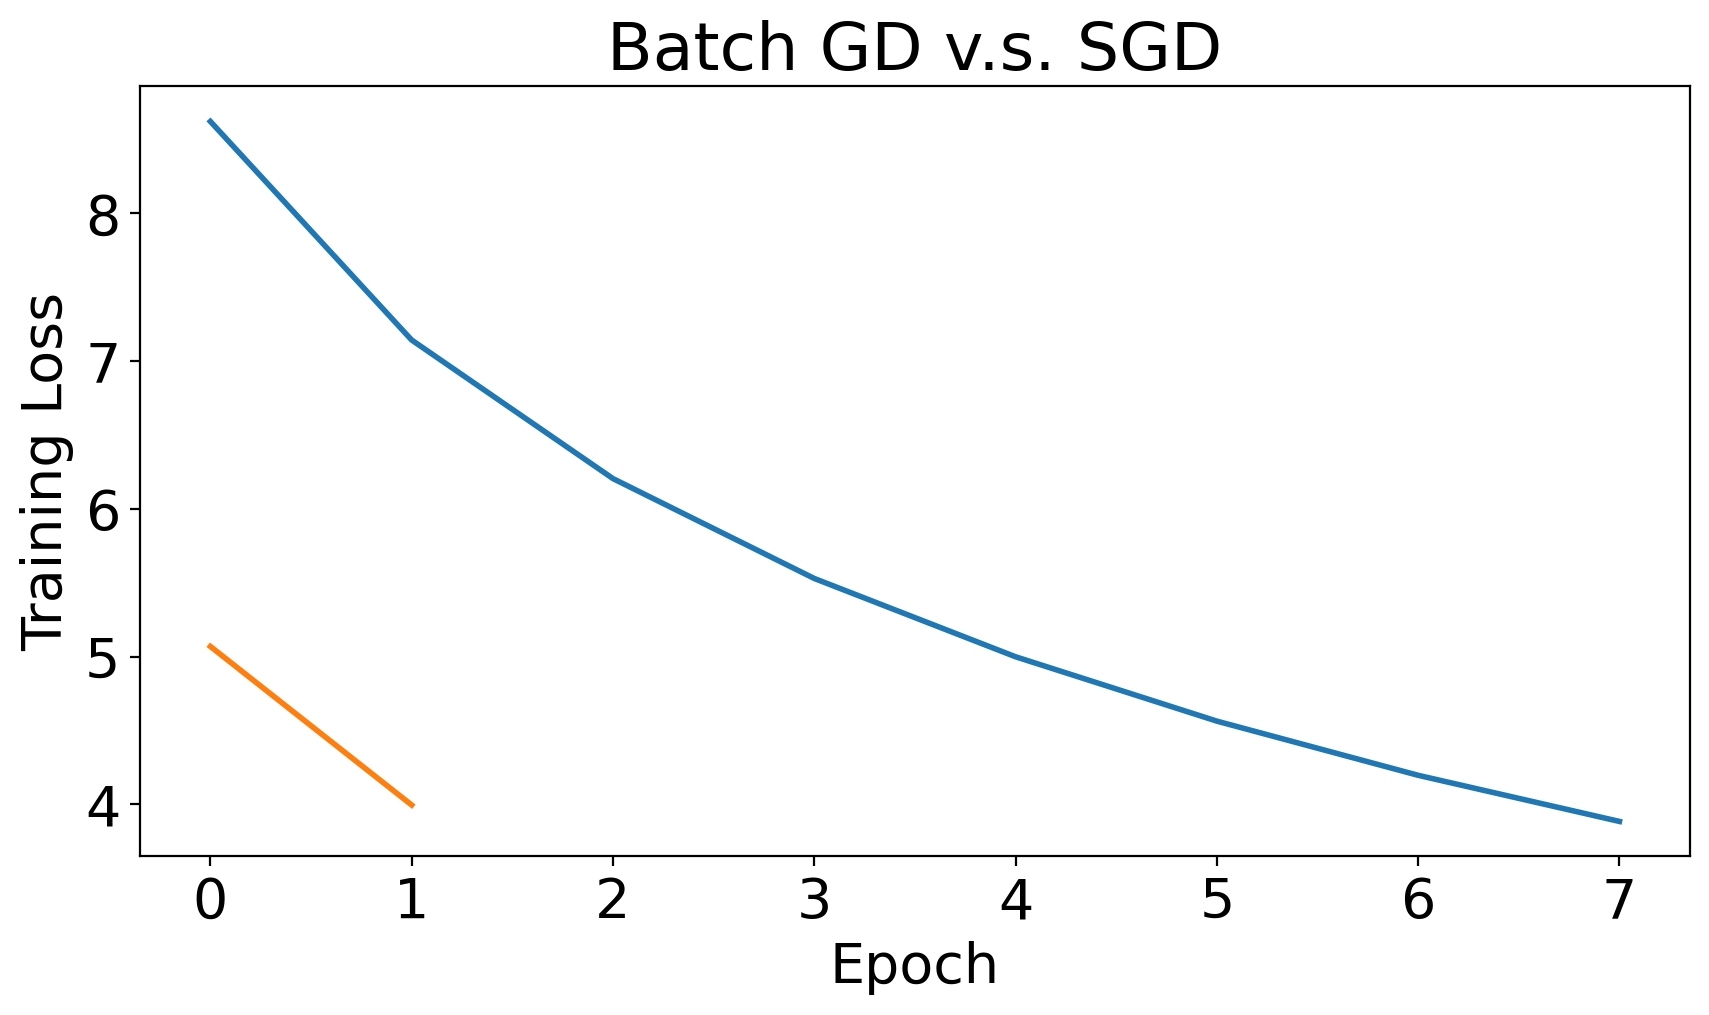

In [232]:
# TODO: Use your own hyperparameters if needed.
# You may need to use different hyperparameters for Batch GD and SGD.

_, info_gd = linear_regression.batch_gradient_descent(X_train, y_train, eta=eta_gd)
_, info_sgd = linear_regression.stochastic_gradient_descent(X_train, y_train, eta=eta_sgd)

fig, ax = plt.subplots()
ax.plot(info_gd["train_losses"], linewidth=2.0, label='Batch GD')
ax.plot(info_sgd["train_losses"], linewidth=2.0, label='Stochastic GD')

# NOTE: It is always a good practice to include label and title for matplotlib plots.
ax.set_title("Batch GD v.s. SGD")
ax.set_ylabel("Training Loss")   # Note: see the CHANGELOG (rev4).
ax.set_xlabel("Epoch")
plt.show()

## 2.2: Overfitting Study

### 2(d): Implementing the closed form solution

Next, you will investigate the problem of overfitting. Recall the figure from the Lecture 2~3, which explores over-fitting as a function of the degree of the polynomial $M$.

As instructed in the problem set, we will use the closed form solution of linear regression instead of iterative optimizations.
<span class="instruction">Implement the function `linear_regression.closed_form()`, which gives the optimal solution of the linear regression</span> that minimizes the following loss function:

$$
E(\mathbf w) = \frac{1}{2} \sum_{i=1}^N \left( \sum_{j=0}^M w_j \phi_j(x^{(i)}) - y^{(i)} \right)^2 = \frac{1}{2} \sum_{i=1}^N ({\mathbf w}^\top \phi(x^{(i)}) - y^{(i)})^2
$$

In [233]:
linear_regression.closed_form?
# print(linear_regression.closed_form(X_train,y_train))

Signature:
linear_regression.closed_form(
    X_train: numpy.ndarray,
    y_train: numpy.ndarray,
    *,
    lam: float = 0.0,
) -> numpy.ndarray
Docstring:
Return the closed form solution of linear regression.

Arguments:
    X_train: The X feature matrix, shape (N, M+1).
    y_train: The y vector, shape (N).
    M: The degree of the polynomial to generate features for.
    lam: The regularization coefficient lambda.

Returns:
    The (optimal) coefficient w for the linear regression problem found,
    a numpy array of shape (M+1, ).
File:      e:\umichcourses\eecs 545_machine learning\hw1\hw1.rev4\linear_regression.py
Type:      function

### 2(e): Plot generation

<span class="instruction">Task: Regenerate the chart as instructed in the problemset: plot $E_\text{RMS}$ (y-axis) over $M=0,1,\cdots,8,9$ (x-axis).</span>

To find the parameters, use the closed form solution of linear regression (assuming all the condition is met) that minimize the error for a $M$-degree polynomial (for $M = 0, \ldots, 9$) for the training data `x_train` (q2xTrain.npy) and `y_train` (q2yTrain.npy). For the test curve, use the data in `x_test` (q2xTest.npy) and `y_test` (q2yTest.npy)

Note: For different values of $M$, we assume the feature vector is
$$
    \phi(x^{(i)}) = \big[ 1, x^{(i)}, (x^{(i)})^2, \cdots, (x^{(i)})^M \big]
$$
for each $x^{(i)}$.

In [234]:
X_train = linear_regression.generate_polynomial_features(x_train, M=9)
w_closed = linear_regression.closed_form(X_train, y_train)
print(f"w_closed = {w_closed}")

w_closed = [ 6.35802176e+00 -2.31141552e+02  3.77805773e+03 -3.00747083e+04
  1.35521730e+05 -3.68894274e+05  6.16766879e+05 -6.18333297e+05
  3.40637103e+05 -7.91943335e+04]


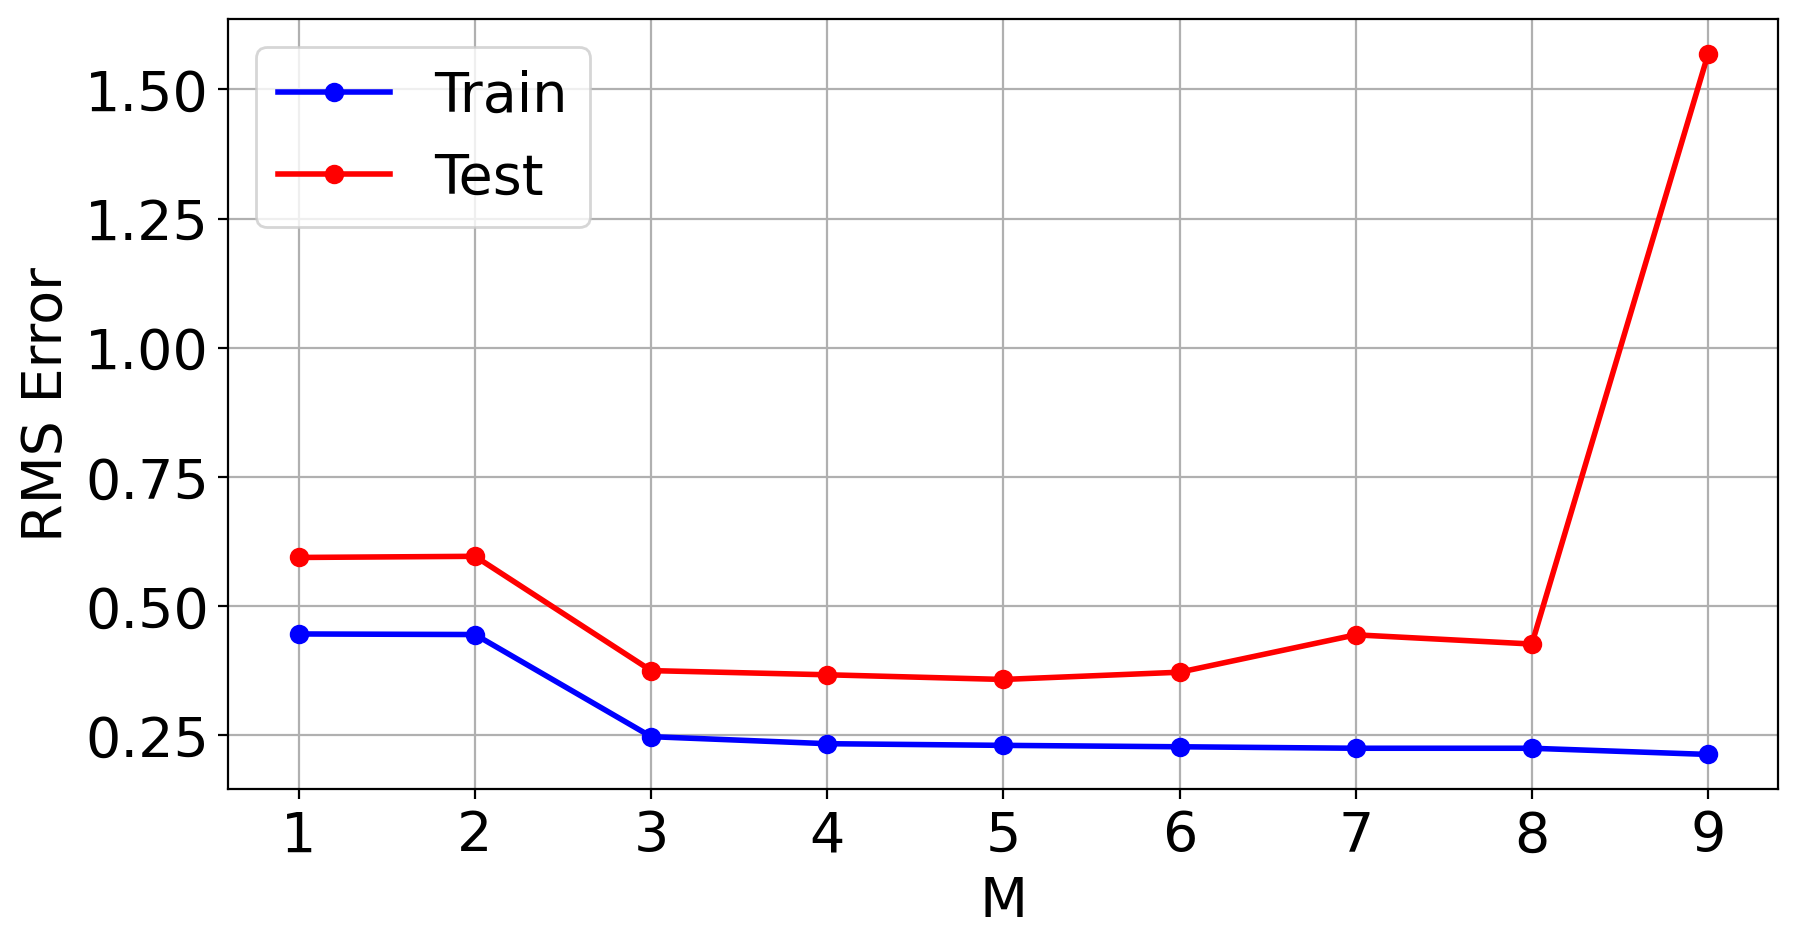

In [235]:
from typing import Sequence
fig, ax = plt.subplots()

#############################################################################
# TODO: Implement the plot                                                  #
#############################################################################

def gen_data(x_train, y_train, x_test, y_test,
             M_candidates: Sequence[float]):

#     raise NotImplementedError("TODO: Add your implementation here.")
    x_train, y_train, x_test, y_test = linear_regression.load_data()
    train_rms_errors = np.zeros(len(M_candidates))  # TODO: Remove dummy implementations.
    test_rms_errors = np.ones(len(M_candidates))  # TODO: Remove dummy implementations.
    for M in M_candidates:
        X_train = linear_regression.generate_polynomial_features(x_train, M)
        X_test = linear_regression.generate_polynomial_features(x_test, M)
        N_train = X_train.shape[0]
        N_test = X_test.shape[0]

        w_ml = linear_regression.closed_form(X_train,y_train)
        Ew_train = linear_regression.loss(X_train, y_train, w_ml)
        Ew_test = linear_regression.loss(X_test, y_test, w_ml)
        # print(M)
        train_rms_errors[M-1] = np.sqrt(2 * Ew_train / N_train)
        test_rms_errors[M-1] = np.sqrt(2 * Ew_test / N_test)
        # print(train_rms_errors)
        # print(test_rms_errors)
        
    return train_rms_errors, test_rms_errors

#############################################################################
#                          END OF YOUR CODE                                 #
#############################################################################

M = 9
train_rms_errors, test_rms_errors = gen_data(x_train, y_train, x_test, y_test,
                                             M_candidates=np.arange(1, M + 1))

ax.plot(np.arange(1, M + 1), train_rms_errors,
        label='Train', color='b', marker='o', linewidth=2.0)
ax.plot(np.arange(1, M + 1), test_rms_errors,
        label='Test', color='r', marker='o', linewidth=2.0)

ax.grid()
ax.legend()
ax.set(xlabel="M", ylabel="RMS Error")

plt.show()

## 2.3. Regularization


In this section, we will find the coefficients that minimize the error for a $M=9$ degree polynimal given the regularization coefficient $\lambda$, over $\lambda \in \{0, 10^{-8}, 10^{-7}, 10^{-6}, \cdots, 10^{-1}, 10^{0} (=1) \}$.

<span class="instruction">Modify the implementation of `linear_regression.closed_form(...)` so that it takes the regularization coefficient $\lambda$ into consideration.</span> The regularized object function is:
$$
\frac{1}{2} \sum_{i=1}^N (\mathbf w^\top \phi(\mathbf x^{(i)}) - y^{(i)})^2 + \frac{\lambda}{2}\| \mathbf w \|_2^2
$$


In [236]:
X_train = linear_regression.generate_polynomial_features(x_train, M=9)
w_closed = linear_regression.closed_form(X_train, y_train, lam=1.0)
print(f"w_closed (lambda = 1) = {w_closed}")

w_closed (lambda = 1) = [ 1.22947449 -0.72301958 -0.74894872 -0.49070049 -0.25533698 -0.0835526
  0.03434322  0.11330398  0.16522674  0.1984788 ]


### 2(g): Generate Plot

<span class="instruction">Draw a plot of the **RMS** error over different values of $\log \lambda$ (x-axis).</span>
Be sure to plot the original (un-regularized) $E_\text{RMS}$ when plotting, and also include legend. Use this result and plot to write your answer in the writeup. Which $\lambda$ gives you the best performance?

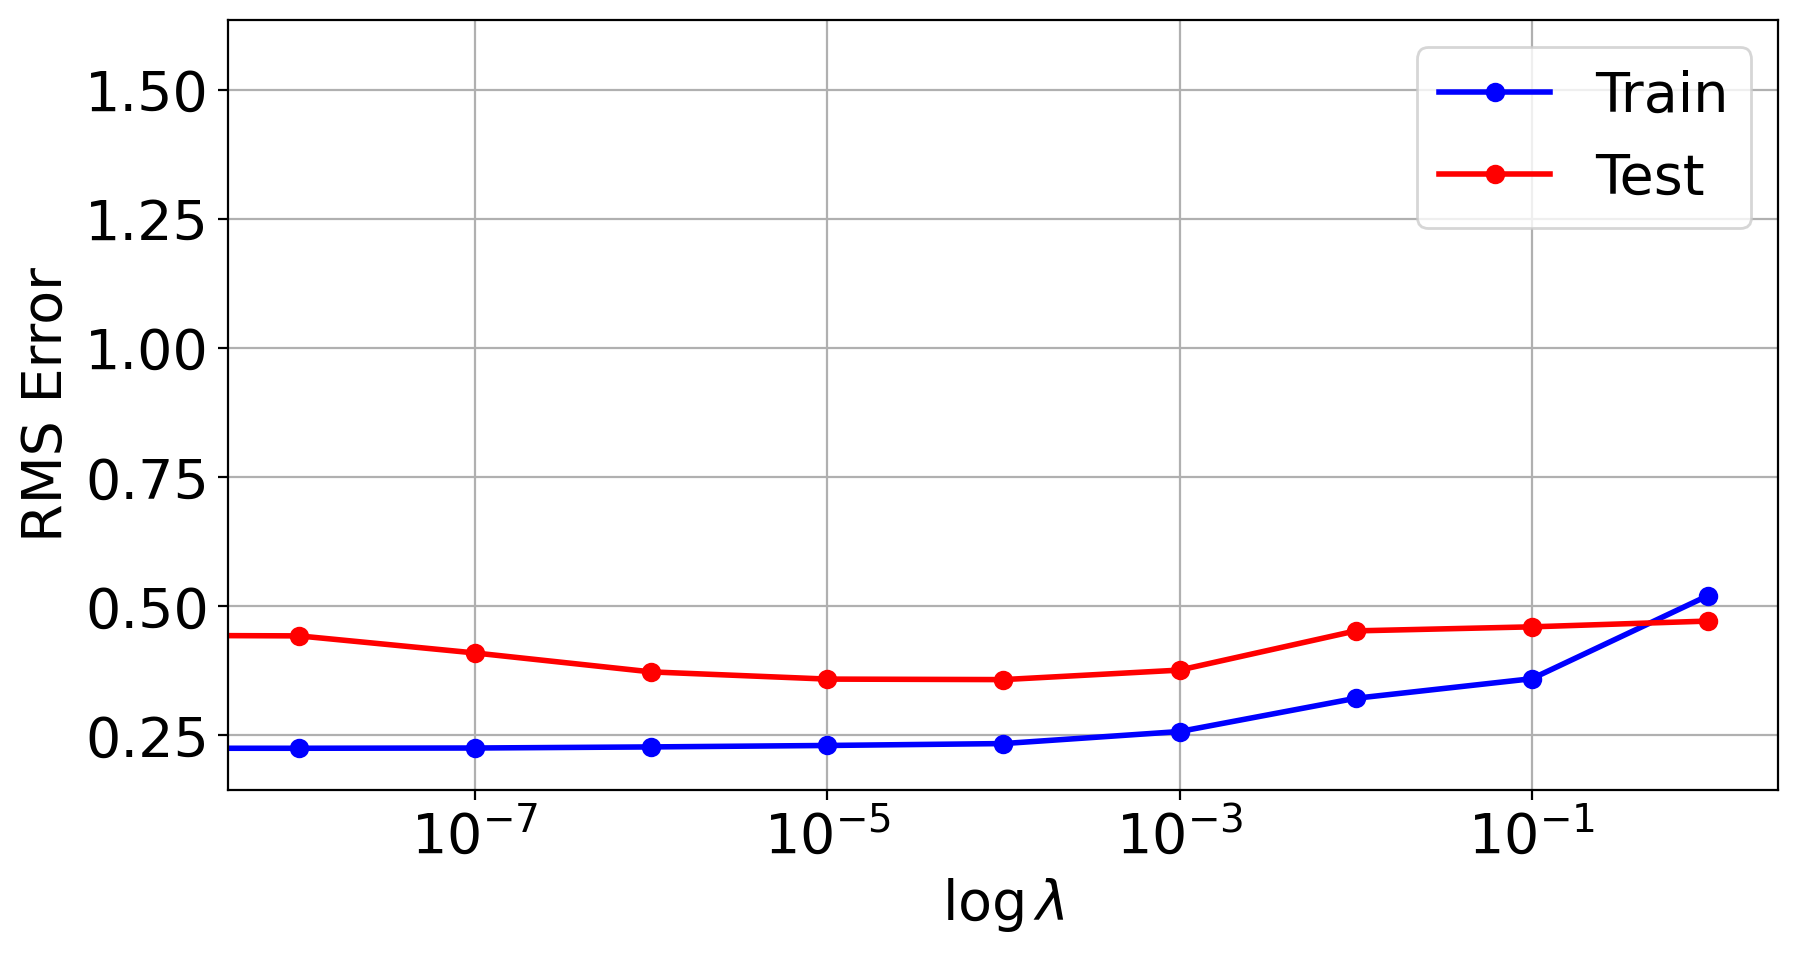

In [237]:
fig, ax = plt.subplots()

#############################################################################
# TODO: Implement the plot for 2(g)
#############################################################################
lam_arr = np.array([0, 1e-8, 1e-7, 1e-6, 1e-5, 1e-4, 1e-3, 1e-2, 1e-1, 1])
M = 9
train_rms_errors = np.zeros((len(lam_arr),))
test_rms_errors = np.zeros((len(lam_arr),))
n = 0
for lam in lam_arr:
    X_train = linear_regression.generate_polynomial_features(x_train, M=M)
    N_train = X_train.shape[0]
    X_test = linear_regression.generate_polynomial_features(x_test, M=M)
    N_test = X_test.shape[0]
    w_closed = linear_regression.closed_form(X_train, y_train, lam=lam)
    
    Ew_train = linear_regression.loss(X_train, y_train, w_closed)
    Ew_test = linear_regression.loss(X_test, y_test, w_closed)
    train_rms_errors[n] = np.sqrt(2 * Ew_train / N_train)
    test_rms_errors[n] = np.sqrt(2 * Ew_test / N_test)
    n = n+1
# print(train_rms_errors)
# print(test_rms_errors)
ax.plot(lam_arr, train_rms_errors,
        label='Train', color='b', marker='o', linewidth=2.0)
ax.plot(lam_arr, test_rms_errors,
        label='Test', color='r', marker='o', linewidth=2.0)
ax.legend()
# raise NotImplementedError("TODO: Add your implementation here.")
#############################################################################
#                          END OF YOUR CODE                                 #
#############################################################################

ax.grid()
ax.set(xlabel=r"$\log \lambda$", ylabel="RMS Error")
ax.set_xscale('log')

plt.show()

<br/><br/><br/><br/><br/>

## 3. Locally-weighted Linear Regression

In the below cells, you will implement locally-weighted linear regression discussed in Q3(d).

<span class="instruction">
Implement the following function:
</span>

In [238]:
linear_regression.closed_form_locally_weighted?

Signature:
linear_regression.closed_form_locally_weighted(
    X_train: numpy.ndarray,
    y_train: numpy.ndarray,
    r_train: numpy.ndarray,
) -> numpy.ndarray
Docstring:
Return the closed form solution of locally weighted linear regression.

Arguments:
    x_train: The X feature matrix, shape (N, M+1).
    y_train: The y vector, shape (N, ).
    r_train: The local weights for data point. Shape (N, ).

Returns:
    The (optimal) coefficient for the locally weighted linear regression
    problem found. A numpy array of shape (M+1, ).
File:      e:\umichcourses\eecs 545_machine learning\hw1\hw1.rev4\linear_regression.py
Type:      function

You can test and draw the requested plot as follows:

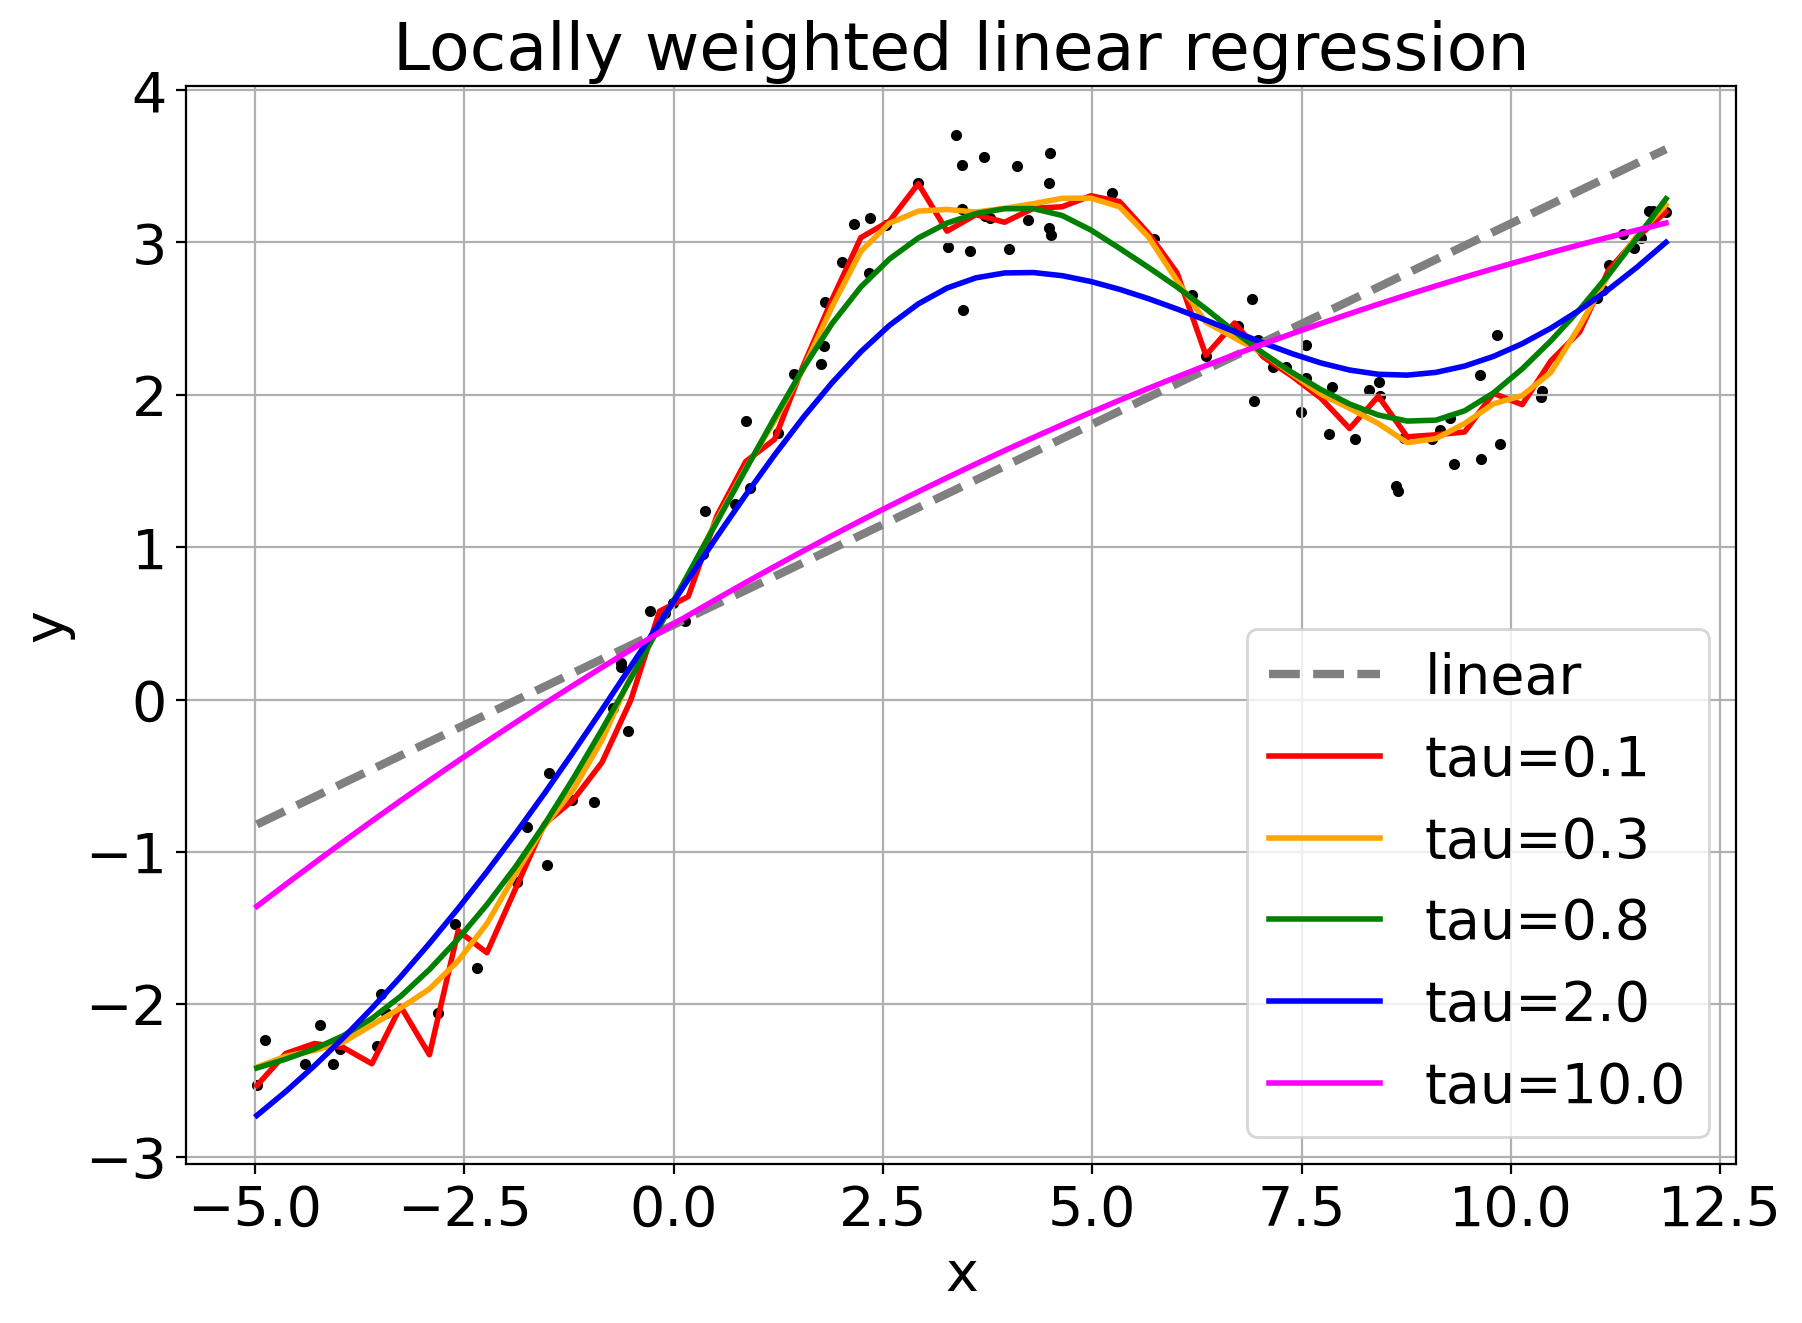

In [239]:
x_train = np.load('data/q3x.npy')
y_train = np.load('data/q3y.npy')
X_train = linear_regression.generate_polynomial_features(x_train, M=1)

# Scatter plot of data
fig, ax = plt.subplots(figsize=(10, 7))

ax.set_title("Locally weighted linear regression")
ax.set(xlabel='x', ylabel='y')
ax.scatter(x_train, y_train, marker='.', c='black')

#
# The ordinary linear regression
#
w_linear = linear_regression.closed_form(X_train, y_train)

x_space = np.linspace(x_train.min(), x_train.max(), num=50)
ax.plot(x_space,
        x_space * w_linear[1] + w_linear[0],
        c='gray', linestyle='--', label='linear', linewidth=3)

#
# Locally-weighted linear regression
#
taus = [0.1, 0.3, 0.8, 2.0, 10.0]
colors = ['red', 'orange', 'green', 'blue', 'magenta']

for color, tau in zip(colors, taus):

    #############################################################################
    # TODO: Implement the plot for 2(g)
    #############################################################################
    y_space = np.zeros_like(x_space)
    N = X_train.shape[0]
    r_train = np.zeros((N,))
    w_weighted = np.zeros((50,2))

    for j in range(len(x_space)):
        for i in range(N):
                # print(i,j)
                r_train[i] = np.exp(-0.5 * np.square(x_space[j] - x_train[i]) / np.square(tau))
        w_weighted[j] = linear_regression.closed_form_locally_weighted(X_train, y_train, r_train)
        y_space[j] = x_space[j] * w_weighted[j][1] + w_weighted[j][0]
#     print(w_weighted)
#     raise NotImplementedError("TODO: Add your implementation here.")

    #############################################################################
    #                          END OF YOUR CODE                                 #
    #############################################################################

    ax.plot(x_space, y_space,
            c=color, label=f'tau={tau}', linewidth=2)

ax.legend()
ax.grid()
plt.show()